# Timeseries pytorch-lightning (CNN)

In [100]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plot
import math
from matplotlib import rc
from pylab import rcParams

import pandas as pd
import numpy as numpy
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [101]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter contrib nbextension install

In [102]:
%matplotlib inline
%config InlineBackend.figure_format='jpeg'
# !jupyter nbextension enable --py widgetsnbextension

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
tqdm.pandas()
pl.seed_everything(42)

Seed set to 42


42

## __Import dataset__

In [103]:
df = pd.read_csv('../datasets/household_power_consumption_v3_drop.txt', parse_dates={'datetime' : ['date','time']}, index_col='datetime', sep=';', usecols=[1,2,3,4,5,6,7,8,9,11,12,13])
df.head(5)

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year
datetime,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006


### Preprocessing

In [104]:
# rows = []

# for _, row in df.iterrows():
#     row_data = dict(
#         grp=row.global_reactive_power,
#         voltage=row.voltage,
#         global_intensity=row.global_intensity,
#         kitchen=row.kitchen,
#         laundry_room=row.laundry_room,
#         thermal_utilities=row.thermal_utilities,
#         day=row.day,
#         month=row.month,
#         year=row.year
#     )
#     rows.append(row_data)
# features_df = pd.DataFrame(rows)

In [105]:
cols = ['global_reactive_power', 'voltage', 'global_intensity', 'kitchen', 'laundry_room', 'thermal_utilities', 'day', 'month', 'year', 'global_active_power']
features_df = df[cols]
features_df

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,0.418,234.84,18.4,0.0,1.0,17.0,16,12,2006,4.216
2006-12-16 17:25:00,0.436,233.63,23.0,0.0,1.0,16.0,16,12,2006,5.360
2006-12-16 17:26:00,0.498,233.29,23.0,0.0,2.0,17.0,16,12,2006,5.374
2006-12-16 17:27:00,0.502,233.74,23.0,0.0,1.0,17.0,16,12,2006,5.388
2006-12-16 17:28:00,0.528,235.68,15.8,0.0,1.0,17.0,16,12,2006,3.666
...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.000,240.43,4.0,0.0,0.0,0.0,26,11,2010,0.946
2010-11-26 20:59:00,0.000,240.00,4.0,0.0,0.0,0.0,26,11,2010,0.944
2010-11-26 21:00:00,0.000,239.82,3.8,0.0,0.0,0.0,26,11,2010,0.938


In [106]:
cut_df = features_df[:500000]
train_size = int(len(cut_df) * .9)
train_size

450000

In [107]:
train_df, test_df = cut_df[:train_size], cut_df[train_size + 1:]
train_df.shape, test_df.shape

((450000, 10), (49999, 10))

In [108]:
# scalling data only using train df
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [109]:
train_df = pd.DataFrame(
    scaler.transform(train_df), 
    index=train_df.index, 
    columns=train_df.columns)
train_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.271777,-0.195321,-0.217391,-1.0,-0.974359,0.7,0.0,1.0,-1.0,-0.219116
2006-12-16 17:25:00,-0.240418,-0.281106,-0.017391,-1.0,-0.974359,0.6,0.0,1.0,-1.0,-0.003022
2006-12-16 17:26:00,-0.132404,-0.305211,-0.017391,-1.0,-0.948718,0.7,0.0,1.0,-1.0,-0.000378


In [110]:
test_df = pd.DataFrame(
    scaler.transform(test_df), 
    index=test_df.index, 
    columns=test_df.columns)
test_df.head(3)

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2007-10-27 22:57:00,-1.000000,0.453385,-0.982609,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:58:00,-0.850174,0.450549,-0.956522,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.958444
2007-10-27 22:59:00,-0.850174,0.441333,-0.965217,-1.0,-1.0,-1.0,0.733333,0.636364,1.0,-0.961844


__To sequences__

In [111]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, offset = 1):
    sequences = []
    data_size = len(input_data)
    
    for i in range(data_size - sequence_length):
        sequence = input_data[i:i+sequence_length]
        
        label_poisition = i+sequence_length
        label = input_data.iloc[label_poisition:label_poisition+offset][target_column]
        
        sequences.append((sequence, label))
        
    return sequences

In [112]:
input_data = train_df[:100]

train_df[:500000]

,global_reactive_power,voltage,global_intensity,kitchen,laundry_room,thermal_utilities,day,month,year,global_active_power
datetime,,,,,,,,,,
2006-12-16 17:24:00,-0.271777,-0.195321,-0.217391,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,-0.219116
2006-12-16 17:25:00,-0.240418,-0.281106,-0.017391,-1.0,-0.974359,0.6,0.000000,1.000000,-1.0,-0.003022
2006-12-16 17:26:00,-0.132404,-0.305211,-0.017391,-1.0,-0.948718,0.7,0.000000,1.000000,-1.0,-0.000378
2006-12-16 17:27:00,-0.125436,-0.273307,-0.017391,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,0.002267
2006-12-16 17:28:00,-0.080139,-0.135767,-0.330435,-1.0,-0.974359,0.7,0.000000,1.000000,-1.0,-0.323007
...,...,...,...,...,...,...,...,...,...,...
2007-10-27 22:51:00,-1.000000,0.431407,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:52:00,-1.000000,0.463311,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199
2007-10-27 22:53:00,-1.000000,0.473945,-0.982609,-1.0,-1.000000,-1.0,0.733333,0.636364,1.0,-0.976199


In [113]:
train_seq = create_sequences(input_data, 'global_active_power', 20, 1)

In [114]:
print(f'Train sequence shape (features): {train_seq[0][0].shape}; (labels): {train_seq[0][1].shape}')

Train sequence shape (features): (20, 10); (labels): (1,)


In [115]:
num_seq = 60 # 60 minutes
offset = 1
train_sequences = create_sequences(train_df, 'global_active_power', num_seq, offset)
test_sequences = create_sequences(test_df, 'global_active_power', num_seq, offset)


### Create pytorch dataset (time-series)

https://www.youtube.com/watch?v=ODEGJ_kh2aA

In [116]:
class PCDataset(Dataset):
    def __init__(self, sequences):
        # super().__init__()
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device='cuda') if torch.cuda.is_available() else torch.Tensor(sequence.to_numpy()), # put to cuda device if available
            label = torch.Tensor(label).float().to(device='cuda') if torch.cuda.is_available() else torch.Tensor(label).float() # put to cuda device if available
        )
        

In [117]:
class PCDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        print('batch size', self.batch_size)
    def setup(self, stage=None):
        self.train_dataset = PCDataset(self.train_sequences)
        self.test_dataset = PCDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=2
        )

In [118]:
# # d = PCDataModule(train_sequences, test_sequences)
# dl = DataLoader(
#     PCDataset(train_sequences),
#     batch_size=8,
#     shuffle=False
# )

# for d in dl:
#     print(d['sequence'].shape)
#     break

In [119]:
num_epoch = 5
batch_size = 64

data_module = PCDataModule(train_sequences, test_sequences, batch_size)
data_module.setup()

batch size 64


In [120]:
train_dataset = PCDataset(train_sequences)

In [121]:
len(train_sequences)

449940

In [122]:
# train_dataset.__len__()

for item in train_dataset:
    print(item['sequence'].shape)
    break
    print(item['sequence'].shape)
    print(item['label'].shape)
    print(item['label'])
    break

torch.Size([60, 10])


### Model

In [149]:
batch_size = 3
feature_dim = 256
time_step = 16000
hidden_channels = 128

x = torch.rand(batch_size, feature_dim, time_step)
print('input_size:', x.shape)

conv1 = nn.Conv1d(
    in_channels=feature_dim,
    out_channels=hidden_channels,
    kernel_size=2
) # feature_dim, hidden_channels, kernel_size=2
print('kernel_size:', conv1.weight.shape)

conv2 = nn.Conv1d(
    in_channels=hidden_channels,
    out_channels=hidden_channels,
    kernel_size=2
)
print('kernel_size_2:', conv2.weight.shape)


# POOL 1D
pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


# NETWORK
out = conv1(x)
print('output_size_1:',out.shape)
out = out.relu()
out = pool1(out)
print('output_size_pool:',out.shape)


out = conv2(out)
print('output_size_2:',out.shape)
out = out.relu()
out = pool2(out)
print('output_size_pool:',out.shape)
out.shape

out = torch.flatten(out, start_dim=1)
print('flat (view)', out.shape[1])

lin = nn.Linear(in_features=out.shape[1], out_features=32)
lin2 = nn.Linear(in_features=32, out_features=60)

out = lin(out)
y = lin2(out)
print(y)

input_size: torch.Size([3, 256, 16000])
kernel_size: torch.Size([128, 256, 2])
kernel_size_2: torch.Size([128, 128, 2])
output_size_1: torch.Size([3, 128, 15999])
output_size_pool: torch.Size([3, 128, 7999])
output_size_2: torch.Size([3, 128, 7998])
output_size_pool: torch.Size([3, 128, 3999])
flat (view) 511872
tensor([[-0.0600,  0.2360,  0.1026,  0.0060, -0.0886, -0.0686,  0.0971, -0.0038,
          0.1756,  0.0102,  0.0532, -0.1457, -0.1318, -0.0633, -0.0497,  0.0701,
         -0.0694, -0.0244,  0.1059,  0.0392, -0.0494,  0.0237,  0.0265,  0.0553,
          0.0591, -0.1677, -0.0976,  0.0444, -0.1427, -0.0662, -0.0331, -0.1374,
          0.1616,  0.0679,  0.0399,  0.1192,  0.1520, -0.0589, -0.1679, -0.1455,
         -0.1165, -0.1059,  0.0700, -0.1544, -0.0903,  0.2164, -0.0477,  0.1205,
         -0.1234,  0.0764, -0.0674, -0.1320,  0.0253,  0.1204, -0.0124,  0.0057,
          0.0003, -0.0927,  0.0570,  0.0613],
        [-0.0729,  0.2019,  0.1065, -0.0249, -0.0618, -0.0803,  0.0721, -

In [124]:
# CNN
class Model(nn.Module):
    def __init__(self, n_features, n_hidden=64, kernel_size=2):
        super(Model, self).__init__()
        self.n_hidden = n_hidden
        
        # convolution layer
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=n_hidden, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=kernel_size)
        
        # pooling layer
        self.pool1 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        self.pool2 = nn.MaxPool1d(kernel_size=kernel_size, stride=2)
        
        # linear
        self.lin1 = nn.Linear(in_features=hidden_channels, out_features=32)
        self.lin2 = nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = x.relu()
        x = self.pool1(x)
        
        # conv2
        x = self.conv2(x)
        x = x.relu()
        x = self.pool2(x)
        
        # flatten
        x = torch.flatten(x, start_dim=1)
        
        # Dynamically create linear layers if not already created
        if self.lin1 is None:
            n_size = x.size(1)
            self.lin1 = nn.Linear(n_size, 32)
            self.lin2 = nn.Linear(32, 1)

        # Linear layers
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)

In [125]:
# class Model(nn.Module):
#     def __init__(self, n_features, n_hidden=128, n_layers=2) -> None:
#         super().__init__()
#         self.n_hidden = n_hidden
#         self.lstm = nn.LSTM(
#             input_size=n_features, #input feature
#             hidden_size=n_hidden,
#             batch_first=True,
#             num_layers=n_layers,
#             dropout=0.2
#         )
        
#         self.regressor = nn.Linear(n_hidden, 1) # final layer for prediction
        
#     def forward(self, x):
#         self.lstm.flatten_parameters()
        
#         _, (hidden, _) = self.lstm(x) # take the hidden state
#         out = hidden[-1] # take the last layer, which contains the features
        
#         return self.regressor(out)

In [126]:
from typing import Any


from pytorch_lightning.utilities.types import STEP_OUTPUT, OptimizerLRScheduler


class PCPredictor(pl.LightningModule):
    def __init__(self, n_features: int, model = Model):
        super().__init__()
        self.model = Model(n_features)
        self.criterion = nn.MSELoss() #loss function
    
    def forward(self,x,labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']
        
        loss, outputs = self(sequences, labels)
        
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):# -> OptimizerLRScheduler:
        return optim.Adam(self.parameters(), lr=0.0001)

In [127]:
train_df.shape

(450000, 10)

In [128]:
model = PCPredictor(train_df.shape[1])

In [129]:
data_module.train_dataloader()

In [130]:
for item in data_module.train_dataloader():
    # print(item.keys())
    # break
    print(item['sequence'].shape)
    print(item['label'].shape)
    # print(item['label'])
    
    break

torch.Size([64, 60, 10])
torch.Size([64, 1])


In [131]:
import tensorboard

In [132]:
%reload_ext tensorboard

%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 10996), started 4:43:59 ago. (Use '!kill 10996' to kill it.)

In [133]:
checkpoint_callback = ModelCheckpoint(
    dirpath='../checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='pc')

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    callbacks=[checkpoint_callback],
    max_epochs=num_epoch,
    accelerator="gpu",
    devices=1,
    # progress_bar_refresh_rate=30,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [147]:
for d in data_module.train_dataloader():
    print(d['sequence'].shape)
    break

torch.Size([64, 60, 10])


In [151]:
# trainer.fit(model, data_module)

# ERR: Given groups=1, weight of size [64, 10, 2], expected input[64, 60, 10] to have 10 channels, but got 60 channels instead

In [152]:
m = Model(n_features=df.shape[1], n_hidden=64, kernel_size=2)
# m()
# for d in data_module.train_dataloader()

SyntaxError: invalid syntax (4157677135.py, line 3)

### Test dataset

In [88]:
trained_model = PCPredictor.load_from_checkpoint(
    '../checkpoints/best-checkpoint.ckpt', 
    n_features=train_df.shape[1]
)

In [100]:
test_dataset = PCDataset(test_sequences)

predictions = []
labels = []

for item in test_dataset:
    
    # print(item['sequence'])
    # break
    sequence = item['sequence']
    label = item['label']
    
    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

In [107]:
print(len(predictions), len(test_df) - 60)

49939 49939


### Descalling

In [153]:
# print(labels)
# print(test_df.iloc[60:]['global_active_power'].values)
result_df = pd.DataFrame(
    {
        'predictions': predictions,
        'labels': labels
    }
)

In [154]:

import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
result_df.index.values

array([    0,     1,     2, ..., 49936, 49937, 49938], dtype=int64)

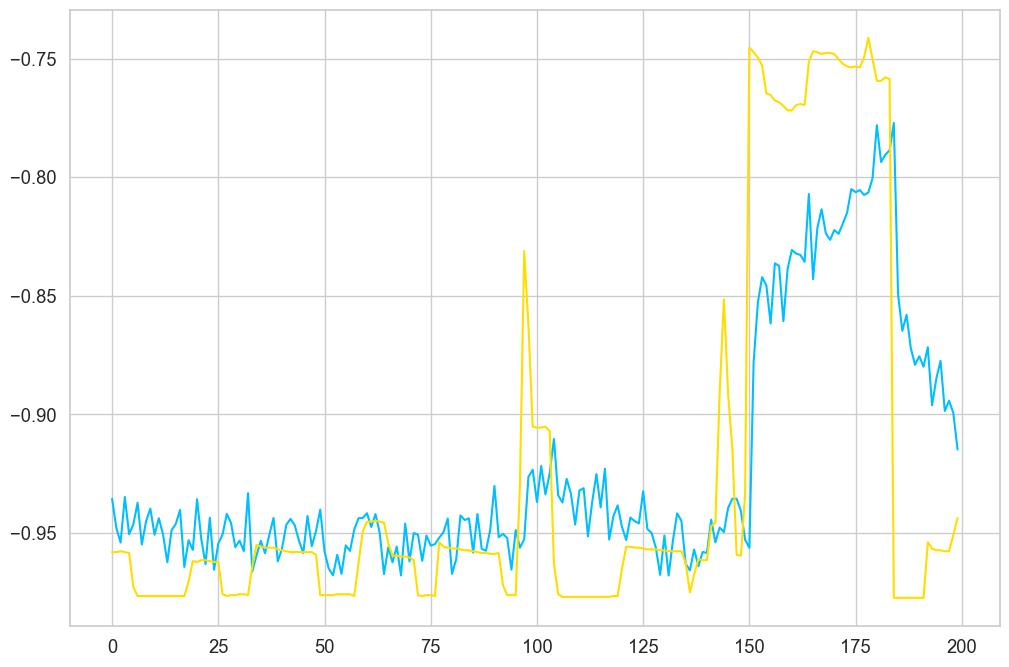

In [160]:
plt.plot(result_df.index.values[:200], result_df.predictions.values[:200])
plt.plot(result_df.index.values[:200], result_df.labels.values[:200])
plt.show()

<Axes: >

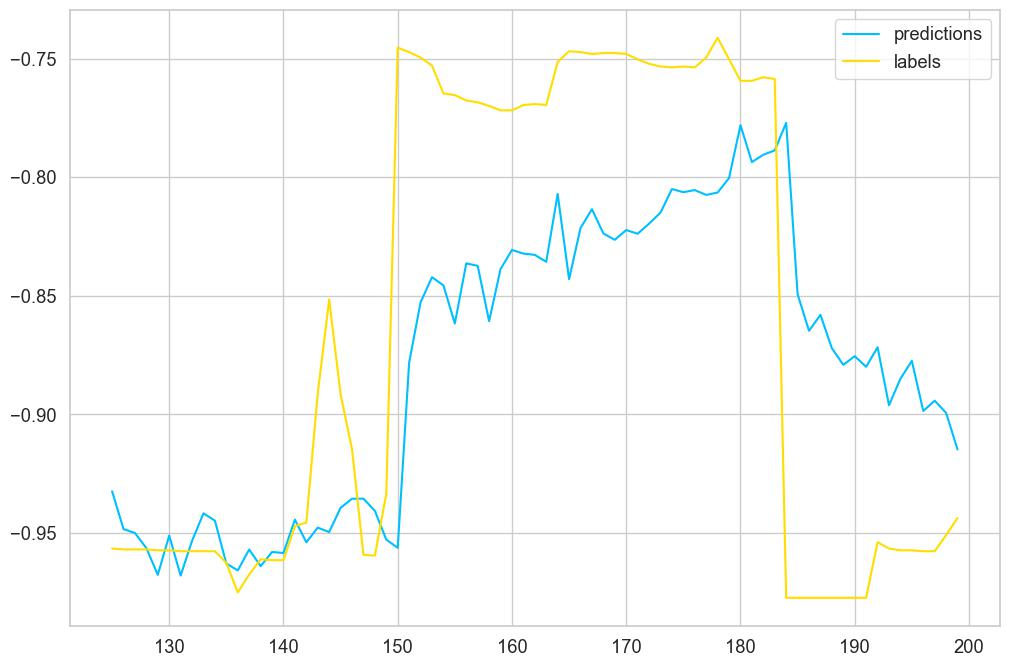

In [163]:
result_df[125:200].plot()